In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Read dataset

In [23]:
import pickle as pkl
import json
import ast
np.set_printoptions(threshold=np.inf)
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet500/"):
    path_set = os.listdir(path)
    dataSet = []
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])
        nb_cons = data_cons.shape[0]
        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])
        nb_var = data_var.shape[0]
        #compose H
        data_cons = np.hstack((np.zeros((data_cons.shape[0],19)),data_cons))
        data_var = np.hstack((data_var,np.zeros((data_var.shape[0],5))))
        matrix_H = np.vstack((data_var,data_cons))
        
        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data = json.load(edges_file)
        matrix_A = np.identity(nb_cons+nb_var)
        for i in range(len(data["values"])):
            iVar,iCons = data["indices"][1][i],data["indices"][0][i] 
            matrix_A[iVar][nb_var+iCons] = data["values"][i]
            matrix_A[iCons+nb_var][iVar] = data["values"][i]
        
        dataSet.append({"X":matrix_H,"Y":data_label,"A":matrix_A})
        
    return np.array(dataSet)
split = [0.70,0.15,0.15]
dataSet = load_data()
data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)


# GCN






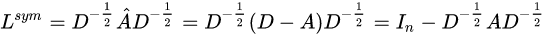

In [3]:
class MLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.activate = nn.ReLU()
        
    def forward(self, x, A):
        x = self.linear(x)
        x = self.activate(x)
        x = A.mm(x)       
        return x
    
class Net(nn.Module):
    def __init__(self, in_channel,aux_channel,out_channel):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            
            
            nn.ReLU(),
            nn.Linear(aux_channel, aux_channel),
        )
        self.mlp = MLP(in_channel, aux_channel)
        self.outlayer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, out_channel),
#             nn.LogSoftmax()
            nn.Sigmoid()
        )
    
    def forward(self, x, A,nb_net):
        x = self.mlp(x,A)
        for i in range(nb_net):
            x = self.layer(x)
        x = self.outlayer(x)
        return x

    

## Train


In [4]:
def train(model, x, y,A, optimizer,nb_net,criterion):
    optimizer.zero_grad()
    output = model(x,A,nb_net)[:len(y)].squeeze(dim=-1)
#     print("output",output)
    loss =criterion(output,y)
#     print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(24,10,1).to(device)
nb_net = 4
EPOCHS = 200
optm = Adam(net.parameters(), lr = 0.001)
criterion = nn.BCELoss()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
for epoch in range(EPOCHS):
    if epoch % 20 == 0:
        vloss = []
        accuracy = []
        accuracy_exactly = []
        data_size = len(data_validation)
        for i in range(data_size):
            inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
            A = torch.from_numpy(data_validation[i]['A']).float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            A = A.to(device)
            loss, predictions = train(net,inputs,labels,A,optm,nb_net, criterion)
            aux= torch.Tensor([0.5]).to(device)
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_exactly.append(int(accuracy[-1]==1))
            
#         print(labels,"\n",predictions)
#         print(labels[0:10],y_hat[0:10])
        print("Epoch %d,Loss = %f,Accuracy = %f,Accuracy_Exactly = %f"%(epoch,np.mean(vloss),np.mean(accuracy),np.sum(accuracy_exactly)/len(accuracy_exactly)))

    for i in range(len(data_train)):
        valid_inputs, valid_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        valid_inputs = valid_inputs.to(device)
        valid_labels = valid_labels.to(device)
        A = A.to(device)
        loss, predictions = train(net,valid_inputs,valid_labels,A,optm,nb_net, criterion)

cuda
Epoch 0,Loss = 0.445904,Accuracy = 0.953467,Accuracy_Exactly = 0.000000


KeyboardInterrupt: 

In [143]:
print(labels,"\n",y_hat)

tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]) 
 tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
